# Aplicación de algoritmo RollingBall

En este script se pretende replicar la experiencia con el algoritmo rollingball del paquete [baseline] de R.

Inicialmente se deben tener instalados los paquetes necesarios para el procesamiento de las imágenes.

Este paso puede **omitirse** si ya se encuentra instalado.

In [ ]:
install.packages("ggplot2")
install.packages("imager")
install.packages("mixtools")
install.packages("baseline")
install.packages("Matrix")

In [22]:
install.packages("rgdal")
install.packages("plotly")
install.packages("EcoGenetics")

Installing package into ‘/home/christian/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)

Warning message in install.packages("rgdal"):
“installation of package ‘rgdal’ had non-zero exit status”
Installing package into ‘/home/christian/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)

Warning message in install.packages("plotly"):
“installation of package ‘plotly’ had non-zero exit status”
Installing package into ‘/home/christian/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plotly’, ‘rgdal’


Warning message in install.packages("EcoGenetics"):
“installation of package ‘plotly’ had non-zero exit status”
Warning message in install.packages("EcoGenetics"):
“installation of package ‘rgdal’ had non-zero exit status”
Warning message in install.packages("EcoGenetics"):
“installation of package ‘EcoGenetics’ had non-zero exit status”


Incorporamos las dependencias necesarias

In [1]:
library(mixtools)
library(baseline)
library(ggplot2)
library(imager)
library(Matrix)

mixtools package, version 1.1.0, Released 2017-03-10
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.



Attaching package: ‘baseline’


The following object is masked from ‘package:stats’:

    getCall


Loading required package: magrittr


Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following object is masked from ‘package:mixtools’:

    depth


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image




In [2]:
library(EcoGenetics)



 
                 --------------------- 
                   || EcoGenetics || 
                 --------------------- 
 
   Version 1.2.1-5 
   GitHub: ecogenetics_devel() 
   Online tutorial: ecogenetics_tutorial() 
   Comments / suggestions / bug reports: learoser@gmail.com 
   Overview: ?EcoGenetics




El primer paso consiste en cargar la imagen en una variable. La representación de la imagen está en el espacio de color RGB.

In [3]:
#Load and plot the RGB file
#data.file <- '/mnt/usb-WD_Elements_25A2_575852314531383859503438-0:0-part1/CHB/PASANTIA/imagenes_forestal/data/DJI_0805.jpg'
data.file <- '../imagenes_forestal/data/DJI_0791.jpg'
im <- load.image(data.file)

Una vez que la imagen se encuentra cargada en la variable, es posible imprimir el gráfico con la función <code>plot</code>

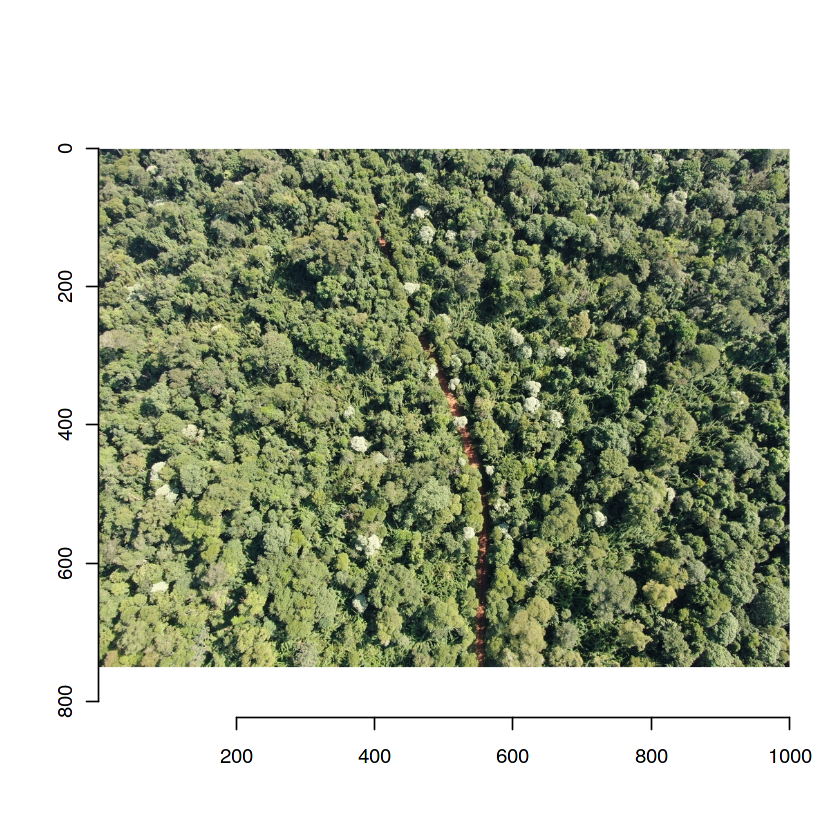

In [4]:
plot(im)

La imagen con la que se trabaja fue obtenida por medio de un dron que sobrevolaba la [reserva biósfera Yaboty](https://sib.gob.ar/area/MISIONES*YB*YABOTY), a una altitud aproximada de 600 metros. La resolución de la imagen original es de 12 Mpixels (4000 x 3000), pero fue reducida a una resolución de 1000 x 750 pixels para aliviar la carga de procesamiento.

Teniendo en cuenta los datos del vuelo, de la [cámara](https://www.dji.com/phantom-4/info) y del terreno, podemos hallar que la resolución espacial de la fotografía aérea es de 0,5 metro por pixel, aproximadamente (esto teniendo en cuenta que la imagen original fue reducida en su resolución original de 4000 x 3000 pixeles a 1000 x 750 pixeles)


In [5]:
data.file <- '../Captura.png'
recorte <- load.image(data.file)
plot(recorte)

In [6]:
data.file <- '../copa_referencia.png'
recorte <- load.image(data.file)
plot(recorte)

Una observación en la imagen del recorte de la copa permite estimar el tamaño que abarca la copa en 80 píxeles. Este dato será usado en los parámetros de los filtro implementados.

Para procesar la imagen, debe ser convertida al espacio de color [HSL](https://es.wikipedia.org/wiki/Modelo_de_color_HSL), del cual se tomará la componente **L** de luminosidad.

In [7]:
#GPerforms the conversion of the image from RGB to HSL colorspace
im_hsl <- RGBtoHSL(im)

In [8]:
plot(im_hsl)

El aspecto de la imagen visualizada en su componente L del espacio HSL es de escala de grises...

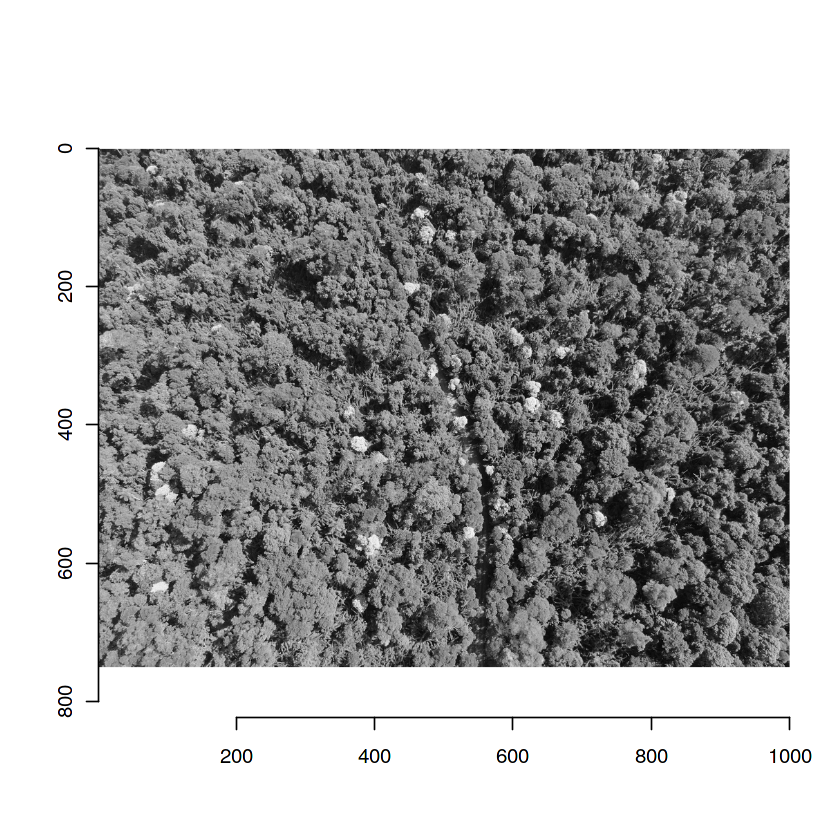

In [9]:
#prints the image L channel from the HSL colorspace. index 3 is L
plot(channel(im_hsl, 3))

Se extrae la componente L de la imagen HSL y se la almacena en una variable

In [10]:
#Extracts the L component from HSL colorspace image
im_L <- im_hsl[,,3]

# Estimación de parámetros de distribución bimodal

La función <code>normalmixEM()</code> devuelve una estimación de parámetros de la distribución de los datos de la componente L de la imagen, considerándola como una distribución normal bimodal...

In [11]:
#Estimation of bimodal distribution parameters
param <- normalmixEM(as.vector(im_L))

number of iterations= 165 


Desplegamos un histograma de los datos del canal L

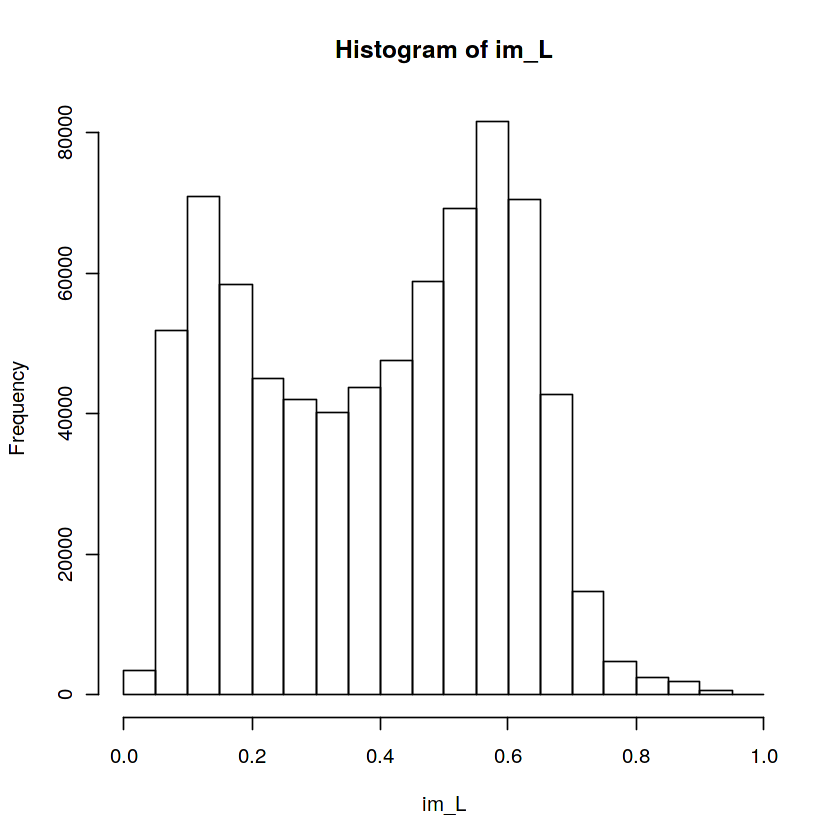

In [12]:
hist(im_L)

# Algoritmo Rolling ball

Se aplica la función <code>baseline()</code> con el método <code>rollingBall</code> y se grafica el resultado. Los parámetros <code>wm</code> y <code>ws</code> corresponden al ancho de ventana local de minimización y maximización y de suavizado respectivamente.

In [13]:
#Rolling ball algorithm

#bc.rollingBall <- baseline(im_L, wm=80, ws=80, method='rollingBall')
## Not run: 
#plot(bc.rollingBall)

Para visualizar el efecto del filtro aplicado mediante el algoritmo RollingBall convertimos los datos corregidos al formato cimg mediante la función <code>as.cimg()</code> y graficamos.

In [14]:
#corregido <- as.cimg(bc.rollingBall@corrected)
#plot(corregido)

# Operaciones matemáticas morfológicas

Se utilizan los operadores matemáticos morfológicos de transformaciones top hat y bottom hat, para mejorarse el contraste, basándose en un elemento estructural.

**Top hat**: es la imagen original en grises menos el resultado de la apertura (*erosión* secundada por *dilación*)

**Bottom hat**: es la imagen resultante de la cerradura (*dilación* secundada por *erosión*) menos la image original en grises
Combinando ambos se obtiene el mejoramiento del contraste sumando a la imagen original el resultado de la transformación top hat y restando el resultado de la transformación bottom hat: *If=I+Ith-Ibh*

In [15]:
#Top hat y bottom hat
mask <- imfill(78,78,val=1)
top_hat <- as.cimg(im_L) - mopening(as.cimg(im_L),mask)
bottom_hat <-  mclosing(as.cimg(im_L),mask) - as.cimg(im_L)
im_filt <- as.cimg(im_L) + top_hat - bottom_hat
plot(im_filt)

# 3. Primer identificación de objetos oscuros


**ENTRADA**: escala de grises (canal L)

**SALIDA**: sombras interarbóreas intensificadas

Se lleva a cabo una primera identificación de objetos oscuros, definiéndolos como los que tienen un valor por debajo de la media en la distribución de grises en brechas (hallada mediante el algoritmo <code>normalmixEM</code>), y a éstos se los iguala a cero.


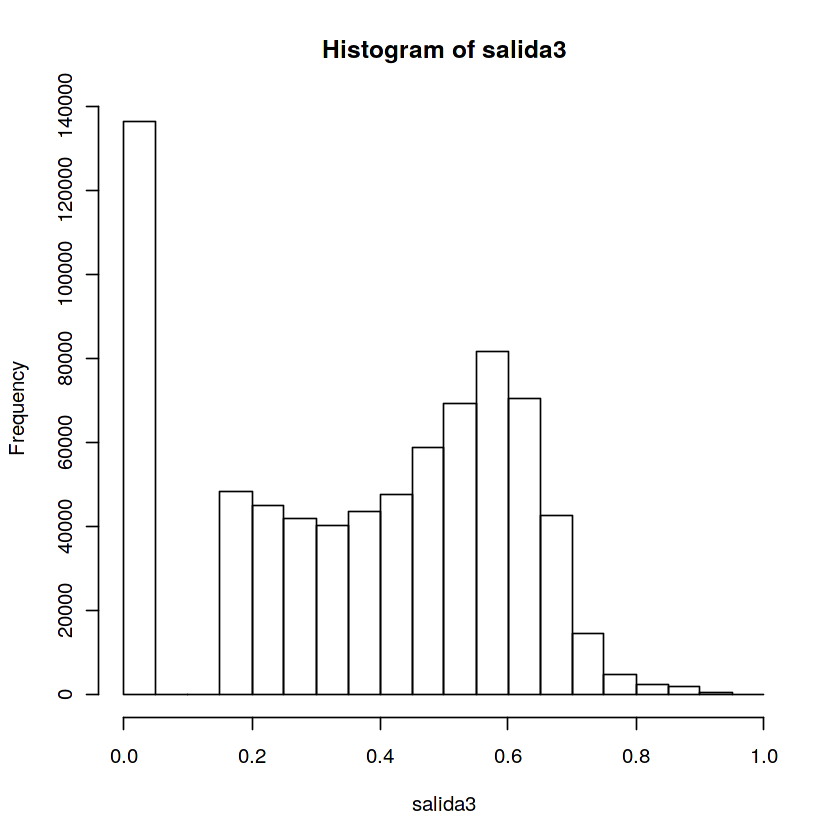

In [16]:
entrada3 <- im_L
#values of image that are lower than mean are set to 0
salida3 <- (entrada3>param$mu[1])*entrada3
plot(as.cimg(salida3))
hist(entrada3)
hist(salida3)

# 4. Relleno de sombras en grandes copas de árboles



**ENTRADA**: escala de grises (canal L)

**SALIDA**: imagen filtrada

La imagen en escala de grises (canal L) se invierte y se le suma el máximo valor de la escala de grises. Esto es comparable con una imagen negativa. Se computan dos imágenes baseline mediante un filtro RollingBall con un radio de tres píxeles. Las imágenes obtenidas se vuelven a invertir, y los valores máximos de la escala de grises se usaron para obtener la imagen final suavizada.


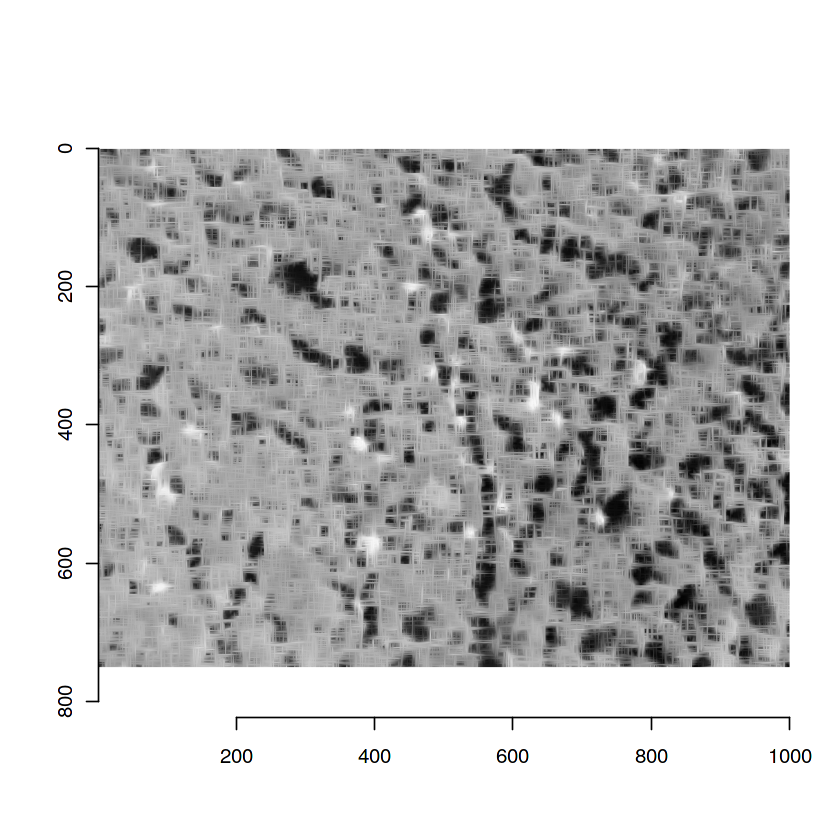

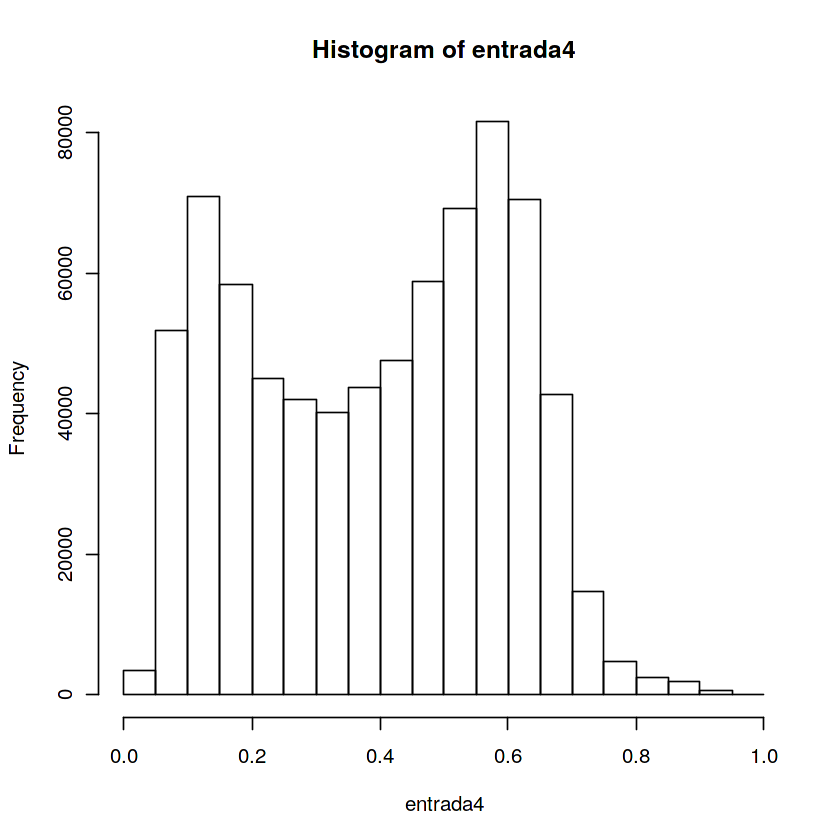

In [17]:
entrada4 <- im_L
#inversion of grayscale image and addition of maximum grayscale value
im_L_inv <- entrada4*(-1)+max(entrada4)
#both baselines bline1 and bline2 are computed considering one input as inverted image and the other input as transposed inverted image
bline1 <- baseline(t(im_L_inv),wm=6, ws=6, method='rollingBall')
bline2 <- baseline(im_L_inv,wm=6, ws=6, method='rollingBall')
#smooth image
im_smooth <- pmax(t(bline1@baseline)*(-1),(bline2@baseline)*(-1))
plot(as.cimg(im_smooth))
salida4 <- im_smooth
hist(entrada4)
hist(salida4)

# 5. Identificar y rellenar huecos en grandes copas de árboles



**ENTRADA**: 

**SALIDA**: 


Se identifican las copas con un diámetro mayor a 15 píxeles, que corresponde a 7,5 metros, mediante una transformación top hat. Para ello se utiliza un elemento estructurante circular con un diámetro de 15 píxeles. El resultado de esto es una máscara binaria que contiene solamente las copas de diámetro mayor a 15 píxeles. Los huecos son rellenados entonces con los valores de escala de grises obtenidos anteriormente.

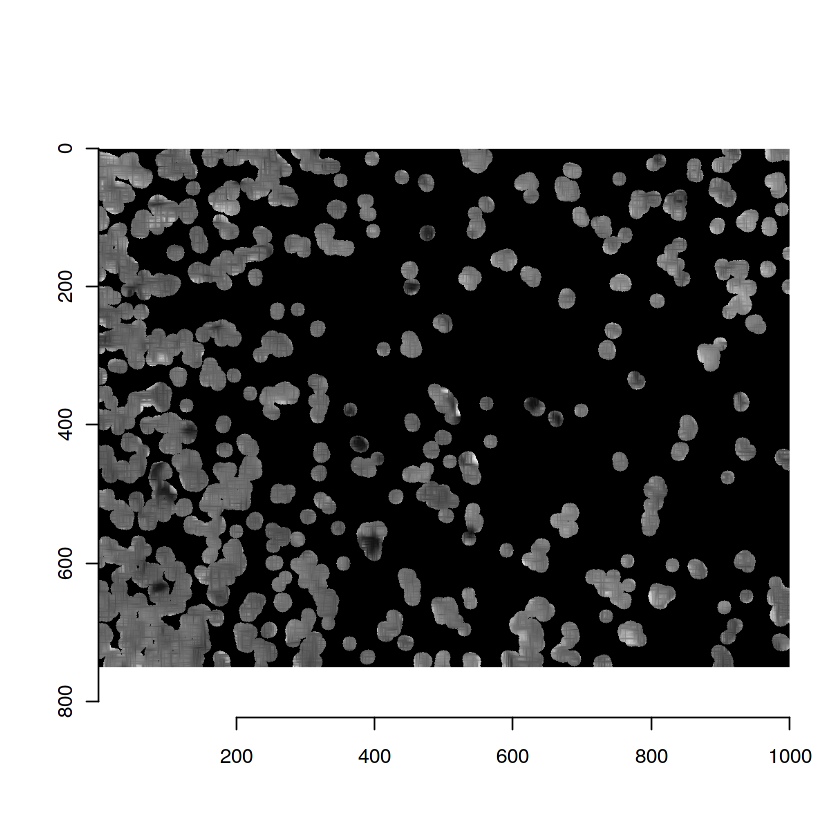

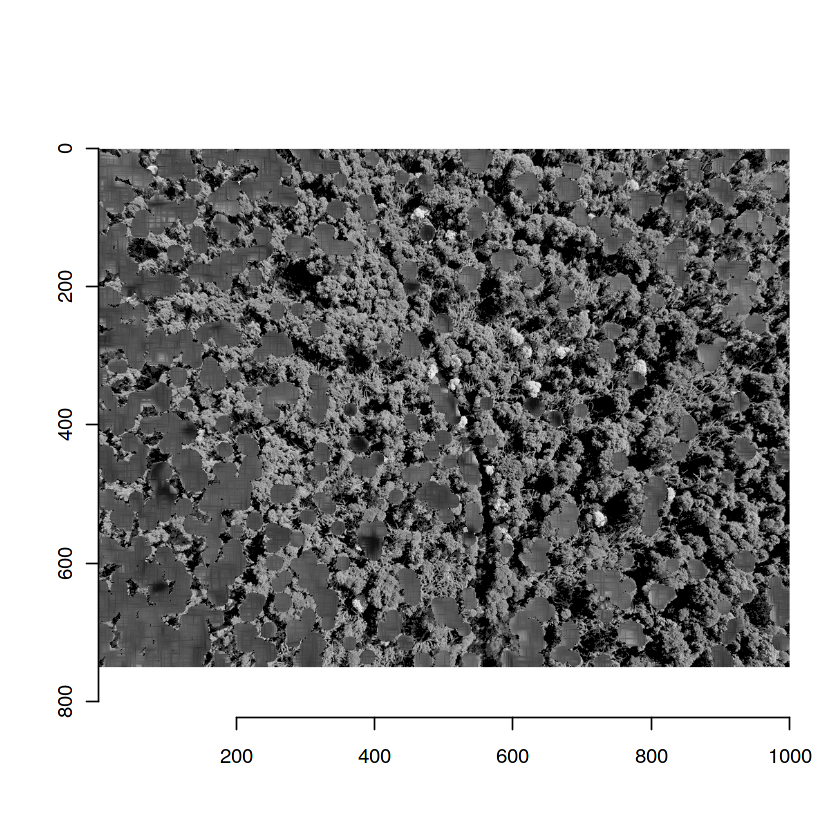

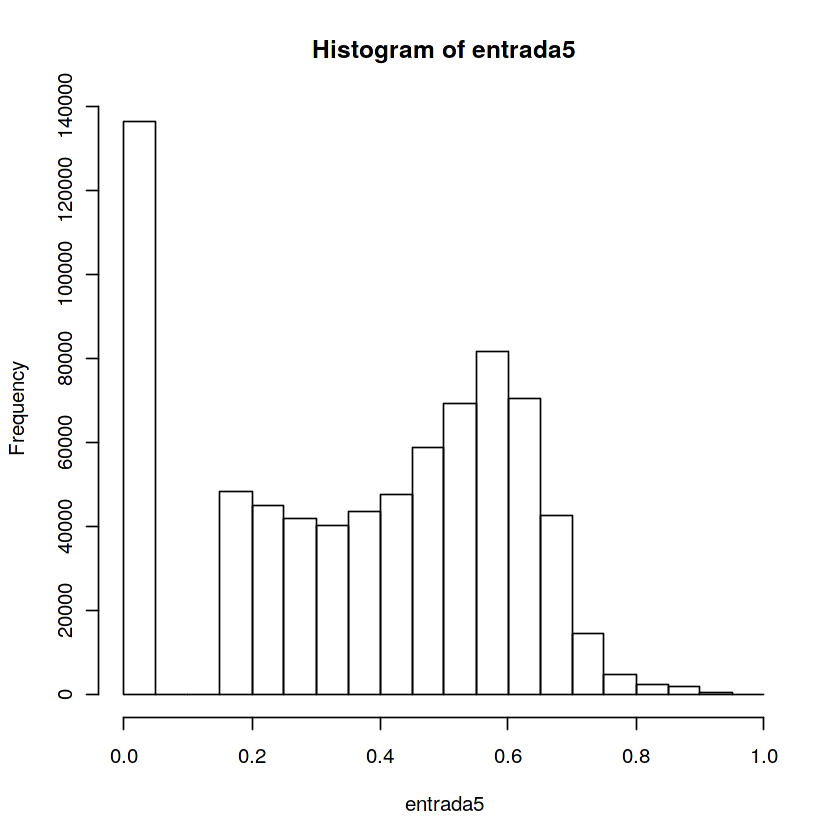

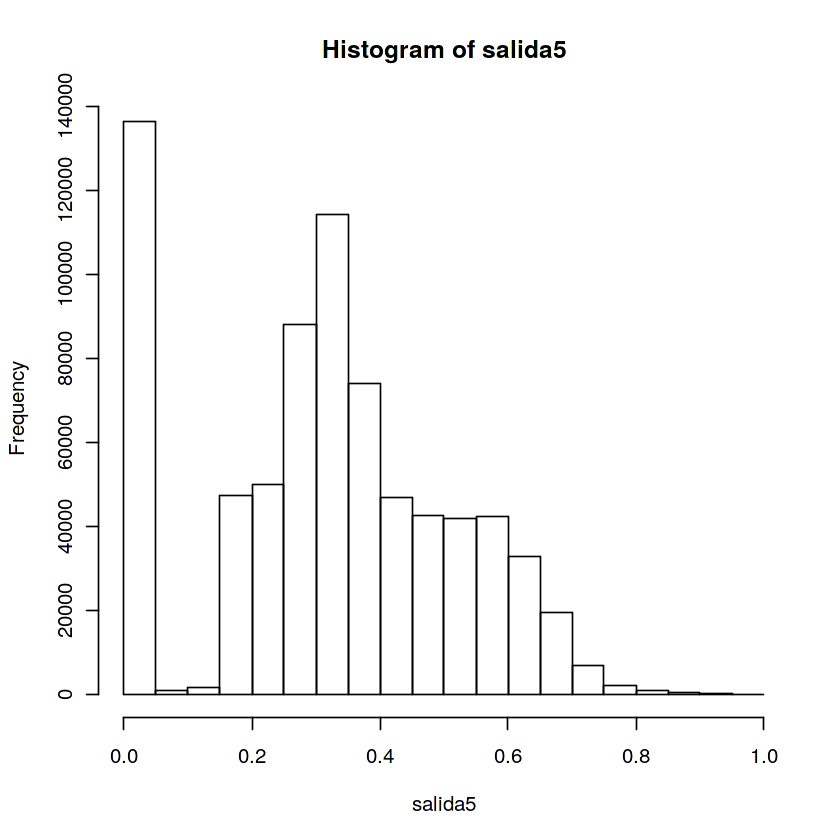

In [18]:
entrada5 <- salida3
#Top hat
#Structuring element consists in a circular shape of determined radius
radio <- 10 #radius of 7 pixels, corresponding to crown diameter
mask <- px.circle(radio)

abertura <- mopening(as.cimg(entrada5),mask,real_mode = FALSE)
t_hat <- as.cimg(entrada5) - abertura
abertura <- abertura>0
plot(as.cimg(abertura))
maskara <- abertura[,,1,1]
salida5 <- (maskara*salida4)*(-1)

plot(as.cimg(salida5))
salida5 <- ((!maskara&entrada5)*entrada5+salida5)
plot(as.cimg(salida5))
hist(entrada5)
hist(salida5)



# 6. Segunda identificación de objetos oscuros¶

**ENTRADA**: salida de la etapa 5

**SALIDA**: imagen de copas sin sombra interna

Bajo la asunción de que la mayoría de los píxeles sombreados de las copas fueron removidos, se lleva a cabo una identificación final de píxeles oscuros, los cuales son definidos como los píxeles de escala de grises que son menores al 99° percentil en la distribuciones en huecos, y se los iguala a cero.

99% 
0.3092955

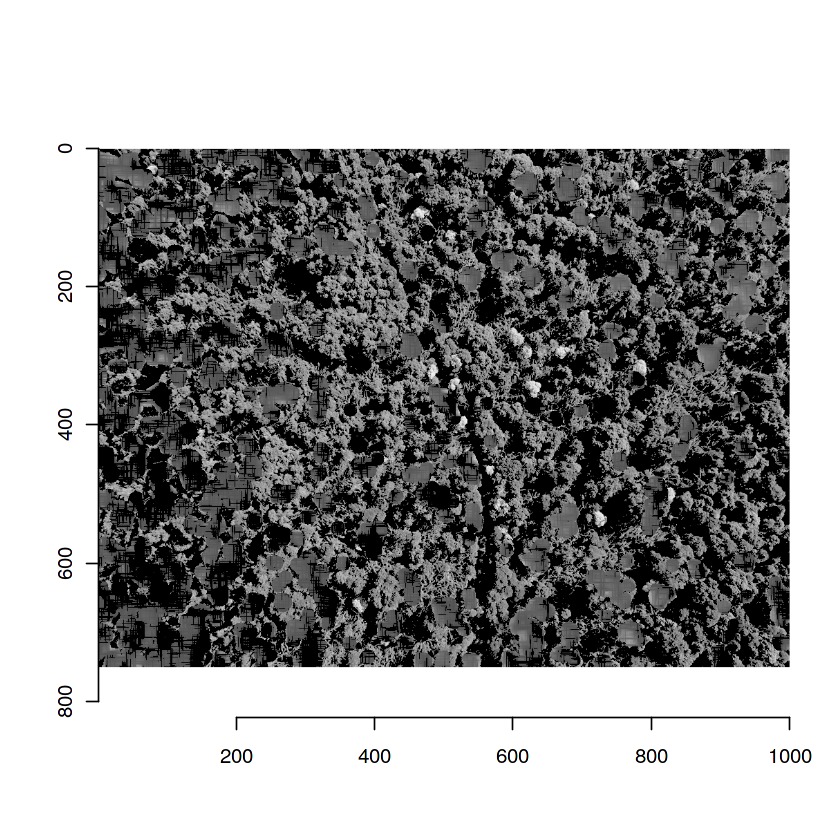

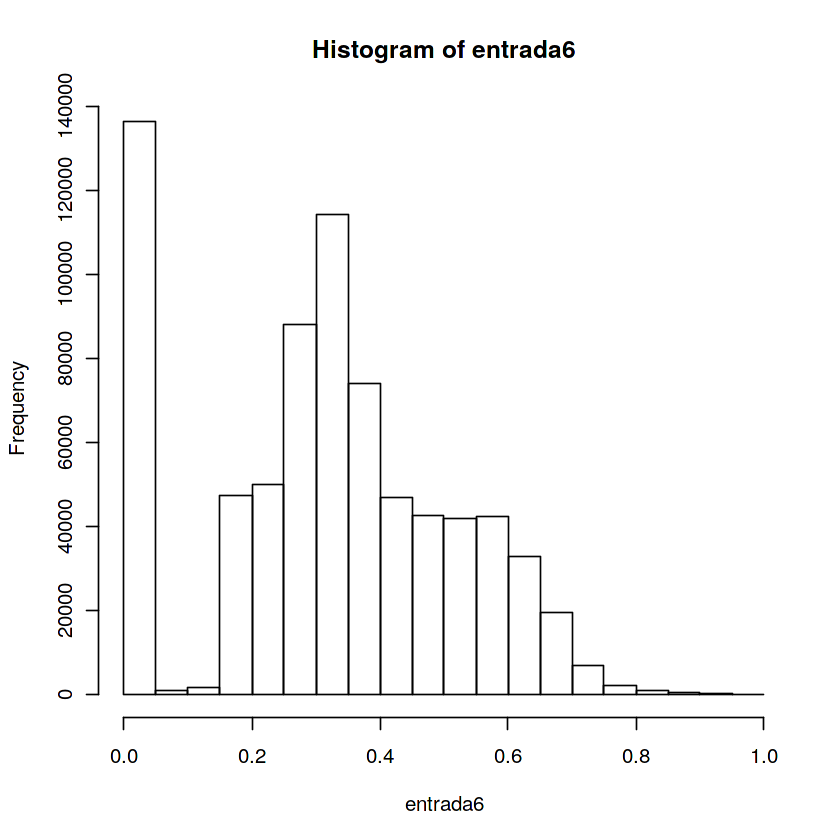

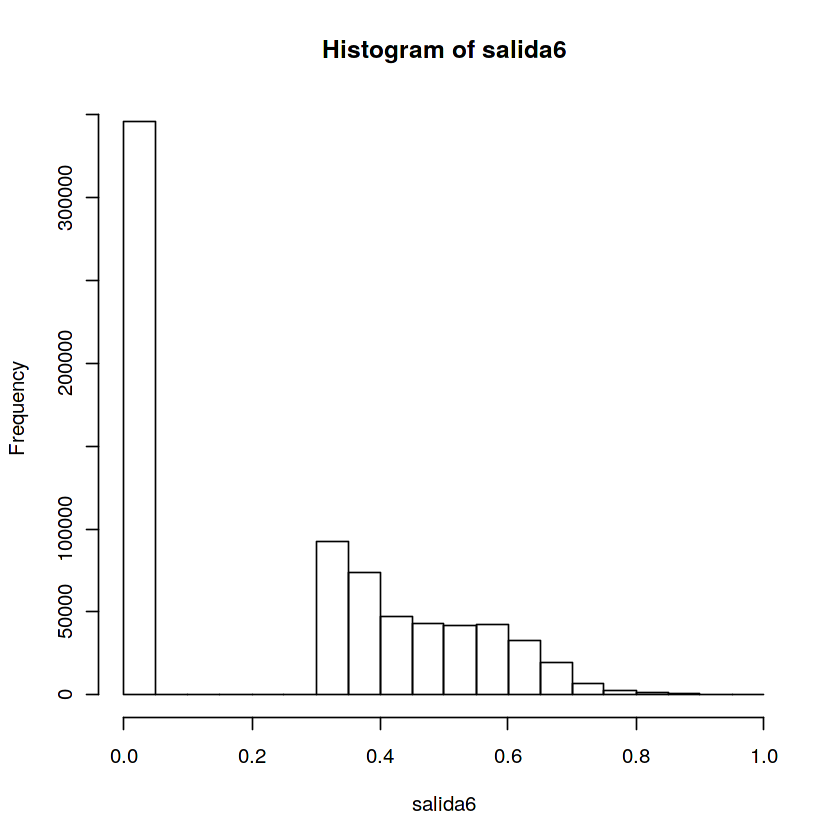

In [19]:
entrada6 <- salida5
#a normal distribution (n_gaps) is generated, using the parameters that were found with normalmixEM (eg. the media and standard deviation)
n_gaps <- rnorm(length(entrada6), mean = param$mu[1], sd = param$sigma[1])
noventaynueve <- quantile(n_gaps,.99)
salida6 <- (!(entrada6[,]<noventaynueve))*entrada6
plot(as.cimg(salida6))
noventaynueve
hist(entrada6)
hist(salida6)

# 7. Hallar pequeños huecos en grandes copas¶

**ENTRADA**: escala de grises (im_L)

**SALIDA**: imagen binaria

Las copas grandes poseen píxeles sueltos de sombra que deben ser rellenados para luego calcular la distancia de los píxeles al borde (o sea los píxeles oscuros). Mediante una ventana de 7 x 7 píxeles se calcula la ocurrencia de valores distintos de cero entorno a cada píxel, los cuales poseen una distribución bimodal. Los huecos en las copas se definen como aquellos que están por encima del 75° percentil. Al final de esta etapa se identifican tres clases de píxel: los de sombra entre árboles, los no sombreados en las copas y los aislados de sombras en las copas. Con estas tres clases se compone una máscara binaria con 0 para píxeles fuera de copas y 1 para los interiores de copas.


In [22]:

entrada7 <- salida6
#square matrix
ras<-matrix(0,1000,250)
ras<-cbind(entrada7,ras)
ras<-ras[200:500,200:500]
#ras is the input data, half side is 3 (as the sliding window is 6x6) and focus distance is 1; function is nnzero
MNZ <- eco.slide.matrix(ras, 3, 1, nnzero)

# mat_riz<-cbind(0,0,0,entrada7,0,0,0)
# mat_riz<-rbind(0,0,0,mat_riz,0,0,0)
# MNZ <- mat_riz*0
# for (i in 3:dim(entrada7)[1]-3) {
#   for (j in 3:dim(entrada7)[2]-3) {
#         MNZ[i,j] <- nnzero(mat_riz[i:i+6,j:j+6])
#   }
#   
# }
setentaycinco <- quantile(MNZ,.75)
huecos_copas <- (entrada7[,]>setentaycinco)*entrada7
salida7 <- huecos_copas
plot(as.cimg(huecos_copas))
setentaycinco

[1] 403920

[1] 750000

[1] 24

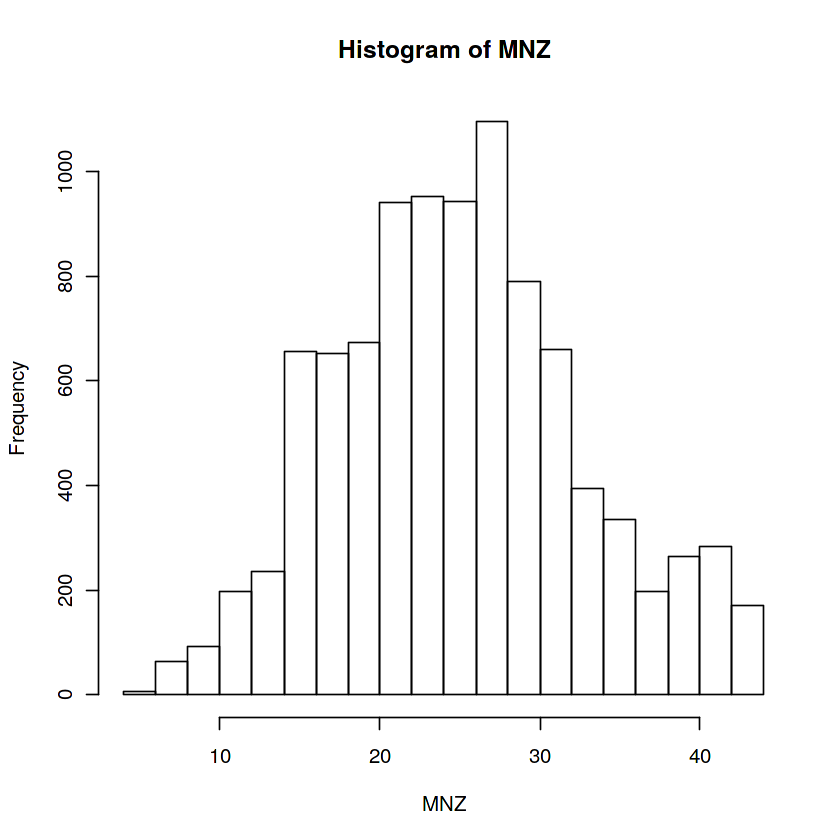

In [21]:
hist(MNZ)
nnzero(entrada7)
length(entrada7)
nnzero(entrada7[1:7,1:7])

# 8. Homogenización de valores de escala de grises en grandes copas

**ENTRADA**: escala de grises (canal L)

**SALIDA**: imagen binaria

Para homogenizar los valores en grises en grandes copas, se calcula la distancia mínima entre valores distinto de cero y el valor de cero de la máscara precedente. Todos los píxeles con distancia mayor a 7 se identifican como grandes árboles, y se rellenan con el valor de la media de los cuatro valores mayores dentro de una ventana de 7 x 7 píxeles.



# 8. Homogenización de valores de escala de grises en grandes copas

**ENTRADA**: escala de grises (canal L)

**SALIDA**: imagen binaria

Para homogenizar los valores en grises en grandes copas, se calcula la distancia mínima entre valores distinto de cero y el valor de cero de la máscara precedente. Todos los píxeles con distancia mayor a 7 se identifican como grandes árboles, y se rellenan con el valor de la media de los cuatro valores mayores dentro de una ventana de 7 x 7 píxeles.



# 9. Extracción de copas antes de la segmentación

**ENTRADA**: escala de grises (canal L)

**SALIDA**: imagen binaria

Las copas con diámetro mayor a 3 metros se extraen mediante un filtro top bottom hat con elemento estructural cuadrado de 6 x 6 píxeles. A partir de esa imagen transformada, se aplica un umbral mayor a 0,001° percentil del filtro.



# 10. Delineación de copas individuales

**ENTRADA**: escala de grises (canal L)

**SALIDA**: imagen binaria

Se calcula la distancia entre valores cero y distinto de cero, es decir la distancia del píxel en la copa al borde. Procesando de manera separada por copas o grupos de copas, calculando las distancias de píxeles a los bordes. Luego se calcula el máximo local en una ventana cuadrada de la máxima distancia al borde del segmento. Para cada máximo local se genera una imagen mediante la dilatación entorno a su locación, con un tamaño que duplique el diámetro.

# Conclusiones